---
# Cairo University Faculty of Engineering
## Deep Learning
## Assignment 2

---

Please write your full name here
- **Name** : "Mahmoud Hamdy Mahmoud Hashim"

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import pandas as pd
import math

from sklearn.datasets import make_blobs  #To generate artificial data
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

**Use TensorFlow unless mentioned otherwise**

# Part 2: Regression

In this part, (**we will implement the entire linear regression method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**)
You will rely only on tensors and auto differentiation.


we will use $n$ to denote
the number of examples in our dataset.
We index the data examples by $i$, denoting each input
as $\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$
and the corresponding label as $y^{(i)}$.


**Linear Model**


We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.

For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix-vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$


**Loss Function**

The most popular loss function in regression problems
is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the squared error is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$


A regression problem for a one-dimensional case is shown below:

<img src="https://i.ibb.co/8cXVC31/fit-linreg.png" alt="fit-linreg" border="0">

To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set.

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we want to find parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$


**Minibatch Stochastic Gradient Descent**


The key technique for optimizing models
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function --> *gradient descent*.

We will settle for sampling a random minibatch of examples
every time we need to compute the update --> *minibatch stochastic gradient descent*.

We can express the update mathematically as follows
($\partial$ denotes the partial derivative):

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$


## Synthetic Data, Simple Model
### Generating the Dataset

To keep things simple, we will [**construct an artificial dataset
according to a linear model with additive noise.**]

In the following code snippet, we generate a dataset
containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix
$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

(**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and**) our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

In [ ]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [ ]:
tf.random.set_seed(5)
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([-0.18030666 -0.95028627], shape=(2,), dtype=float32) 
label: tf.Tensor([7.0726256], shape=(1,), dtype=float32)


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


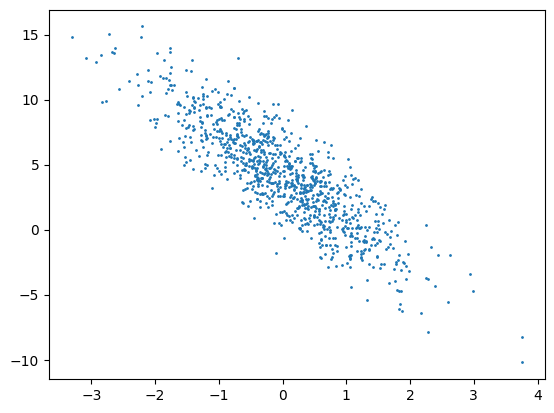

In [ ]:
# The semicolon is for displaying the plot only
plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

### Reading the Dataset

In the following code [**call upon the existing API in a framework to read data.**]
We pass in `features` and `labels` as arguments and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).


1. **Use the tf function from_tensor_slices to generate a tf dataset object with batch_size as input**
2. **Use is_train flag to determine whether to shuffle the dataset or not, set the buffer size appropriately**

In [ ]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a TensorFlow data iterator."""
    #### YOUR CODE HERE ###
    # batchedData = tf.data.Dataset.batch()
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
      dataset = dataset.shuffle(buffer_size=len(features)) #Shuffle across the entire dataset
    dataset = dataset.batch(batch_size=batch_size)
    return dataset

In [ ]:
batch_size = 10
data_iter = load_array((features, labels), 10)

In [ ]:
data_iter

<_BatchDataset element_spec=(TensorSpec(shape=(None, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

3. **Use `iter` to construct a Python iterator and use `next` to obtain the first item from the iterator.**


In [ ]:
### YOUR CODE HERE ###
# Create an iterator over the dataset
print(next(iter(data_iter)))

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-0.20843354,  0.18539536],
       [-2.1175098 , -0.62567085],
       [-0.6580006 , -0.40590936],
       [ 0.60816133,  1.4938267 ],
       [ 0.54980767,  1.2178642 ],
       [-0.4468041 , -0.66064024],
       [-1.0345701 ,  0.04650464],
       [-0.9547455 ,  0.6437773 ],
       [ 0.47753996,  0.774354  ],
       [-2.219429  , -1.5500389 ]], dtype=float32)>, <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[3.1333597 ],
       [2.086135  ],
       [4.2659054 ],
       [0.33680972],
       [1.1452264 ],
       [5.565619  ],
       [1.9795605 ],
       [0.08134682],
       [2.5068717 ],
       [5.003243  ]], dtype=float32)>)


4. **Explain what the output shape in the prvious tensors means:**


**Answer:** It indicates the batch size which in this case is `10` an dthe other shapes indicates the number of features in each data point and the other one represents the label


5. **How many batches are in the **ENTIRE** data_iter ?**

**Answer:** Around `100` batches

### Initializing Model Parameters

6. **Initialize weights by sampling random numbers from a normal distribution with mean 0 and a standard deviation of 0.02, and setting the bias to 0.**

Note: For the shapes of the weights and bias, look at the generating a dataset part


In [ ]:
w = tf.Variable(tf.random.normal(shape=[features.shape[1], labels.shape[1]], mean=0, stddev=0.02))
b = tf.Variable(0.0)
w

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.01420204],
       [ 0.00712033]], dtype=float32)>

### Defining the Model

7. [**define our model, relating its inputs and parameters to its outputs.**]

In [ ]:
def linreg(X, w, b):
    """
    The linear regression model.
    Input:
    - X: input matrix
    - w: weights
    - bias
    """
    ## YOUR CODE HERE ##
    # X->1000*2, w->2*1
    y_hat = tf.matmul(X,w)+b
    return y_hat

### Defining the Loss Function

8. (**define the loss function**): the squared loss function
as described in Loss Function definition above.

Note: In the implementation, you need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [ ]:
def squared_loss(y_hat, y):
    """Squared loss."""
    ## YOUR CODE HERE ##
    loss = tf.reduce_mean(tf.square(y_hat-tf.reshape(y, y_hat.shape)))
    return loss

### Defining the Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.

9. **Filll in the missing function below to apply the minibatch stochastic gradient descent update, given a set of parameters, a learning rate, and a batch size.**

This function should return nothing

Note: use assign_sub


In [ ]:
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""

    ## YOUR CODE HERE ##
    params.assign_sub((lr/batch_size)*grads)

### Training

10. **Implement the following loop**

* For each epoch :
    * For each batch in data_iter:
        * Compute the loss
        * Compute gradient
        * Update parameters
    * Calculate and print the training loss at the end of each epoch



Loss = $ l({x}, {y}) $

Gradient => $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$

Parameters update => $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
.

Don't forget to use GradientTape

Set the number of epochs `num_epochs` and the learning rate `lr` to 5 and 0.02, respectively.

In [ ]:
  for batch_data, batch_label in data_iter:
    print(batch_data.shape[0])
    break

10


In [ ]:
lr = 0.02 ####
num_epochs = 5 #####
net = linreg
loss = squared_loss

In [ ]:
## YOUR CODE HERE ## The loop code
for epoch in range(num_epochs):
  Totalloss = []
  for batch_data, batch_label in data_iter:
    with tf.GradientTape(persistent=True) as tape:
      y_hat = tf.matmul(batch_data, w)+b
      lossVal = loss(y_hat, batch_label)
    grad = tape.gradient(lossVal,[w,b])
    Totalloss.append(lossVal)
    sgd(w, grad[0], lr, batch_data.shape[0])
    sgd(b, grad[1], lr, batch_data.shape[0])
  avgLoss = np.mean(np.array(Totalloss))
  print(f"epoch: {epoch+1}/{num_epochs} .......Train Loss: {avgLoss}")

epoch: 1/5 .......Train Loss: 0.5106049180030823
epoch: 2/5 .......Train Loss: 0.2418723702430725
epoch: 3/5 .......Train Loss: 0.11479730904102325
epoch: 4/5 .......Train Loss: 0.054596878588199615
epoch: 5/5 .......Train Loss: 0.02604321949183941


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.

11. [**evaluate our success in training by comparing the true parameters with those that we learned through our training loop**] (final w, b). They should turn out to be very close to each other.

calculate the difference!!


In [ ]:
## YOUR CODE HERE ##
print(f'error in estimating w: {tf.abs(w[:, 0]-true_w)}')
print(f'error in estimating b: {tf.abs(b-true_b)}')

error in estimating w: [0.07321405 0.0769031 ]
error in estimating b: 0.08723163604736328


## Diabetes Dataset

In this section, we will use SKLEARN's Diabetes dataset

### Loading the Dataset

1. **Load the Diabetes dataset from sklearn**

In [ ]:
from sklearn.datasets import load_diabetes
## YOUR CODE HERE ##
# Load the diabetes dataset
diabetes_data = load_diabetes()

2. **Look at the keys of diabetes_dataset dictionary**

In [ ]:
## YOUR CODE HERE ##

### Look at keys to determine the data

diabetes_data.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

3. **Use the key DESCR to understand the dataset**

In [ ]:
## YOUR CODE HERE ##
print(diabetes_data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

4. **Save the data and target variables in numpy arrays and print their shapes**

In [ ]:
### START CODE HERE ### (≈ 2 lines of code)
### NOTE: Already are a numpy array
data = diabetes_data.data
targets = diabetes_data.target
### END CODE HERE ###

print ('The shape of data is: ' + str(data.shape))
print ('The shape of targets is: ' + str(targets.shape))
print ('I have f = %d features!' % (data.shape[1]))
print ('I have m = %d examples!' % (data.shape[0]))

The shape of data is: (442, 10)
The shape of targets is: (442,)
I have f = 10 features!
I have m = 442 examples!


In [ ]:
diabetes_data.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

5. **What are the ranges of each column in features and the target column?**
    - *Hint* you might find it helpful to convert to pandas dataframe and use ".describe"

In [ ]:
### START CODE HERE ###
df = pd.DataFrame(data= data, columns= diabetes_data.feature_names)
df['target'] = targets
df.describe().loc[['min','max']]
### END CODE HERE ###

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
min,-0.107226,-0.044642,-0.090275,-0.112399,-0.126781,-0.115613,-0.102307,-0.076395,-0.126097,-0.137767,25.0
max,0.110727,0.050680,0.170555,0.132044,0.153914,0.198788,0.181179,0.185234,0.133597,0.135612,346.0


### Preparing the data

6. **Split the data into train and test set using sklearn train_test_split.** Have the test set as 10% of data

In [ ]:
np.random.seed(0)
### START CODE HERE ###
# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

### END CODE HERE ###

print("Shape of training data is", train_data.shape)
print("Shape of training targets is", train_targets.shape)
print("Shape of test data is", test_data.shape)
print("Shape of test targets is", test_targets.shape)

Shape of training data is (397, 10)
Shape of training targets is (397,)
Shape of test data is (45, 10)
Shape of test targets is (45,)


- *feature-wise normalization*: for each feature in the input data (a column in the input data matrix), we subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. This is easily done in NumPy.
- **Question:** Should we normalize features? WHY?
    - ANSWER: I think for this dataset normalization won't make a big difference but in general cases we should normalize the features to improve the performance of the model and get the proper relation between them in the feature space which will make a good reflection in the convergence of the optmization algorithm hence ensures that principal components are not influenced by original scale of the features

7. **normalize the targets**

In [ ]:
### START CODE HERE ### (≈ 6 lines of code)
df['target'] -= np.mean(df['target'])
df['target'] /= np.std(df['target'])
df['target'].describe()
### END CODE HERE ###

count    4.420000e+02
mean    -1.687941e-16
std      1.001133e+00
min     -1.650961e+00
25%     -8.458263e-01
50%     -1.510729e-01
75%      7.709362e-01
max      2.517559e+00
Name: target, dtype: float64

In [ ]:
train_targets_norm = train_targets
train_targets_norm -= np.mean(train_targets)
train_targets_norm /= np.std(train_targets)

In [ ]:
test_targets_norm = test_targets
test_targets_norm -= np.mean(test_targets)
test_targets_norm /= np.std(test_targets)

### Building your model

7. **Use tf.keras.Sequential to build a model with:**
    - 6 hidden layers each having 128 neurons and relu activation.
    - 1 output layer
    - use input_shape argument to specify input size in 1st layer
- **Question:** How many neurons should be in output layer? What should be the activation?
    - ANSWER: 1 neuron, Linear

In [ ]:
def build_model(input_shape):
    ### START CODE HERE ### ()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu',input_shape=[input_shape]),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1)]
    )
    return model

In [ ]:
train_data.shape[0]

397

In [ ]:
# Print the model summary
input_shape=(train_data.shape[1])
# print(input_shape)
model = build_model(input_shape)
print(model.summary())
# input_shape

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_118 (Dense)           (None, 128)               1408      
                                                                 
 dense_119 (Dense)           (None, 128)               16512     
                                                                 
 dense_120 (Dense)           (None, 128)               16512     
                                                                 
 dense_121 (Dense)           (None, 128)               16512     
                                                                 
 dense_122 (Dense)           (None, 128)               16512     
                                                                 
 dense_123 (Dense)           (None, 128)               16512     
                                                                 
 dense_124 (Dense)           (None, 128)             

8. **Compile the model using optimizer=Adam, loss=mean squared loss, metrics=mean absoluute error:**

In [ ]:
### START CODE HERE ### ()
model.compile(loss = 'mse', optimizer = 'adam', metrics=['mae'])

Note that we compile the model with the mse loss function—mean squared error, the
square of the difference between the predictions and the targets. We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the
absolute value of the difference between the predictions and the targets.

9. **FIT the model using for 110 epochs, 64 batch size and a validation split of 0.1**

In [ ]:
### START CODE HERE ### ()
train_hist = model.fit(train_data, train_targets_norm, epochs=110, batch_size=64, validation_split=0.1)

Epoch 1/110
6/6 [==============================] - 1s 37ms/step - loss: 0.9658 - mae: 0.8390 - val_loss: 1.1383 - val_mae: 0.9203
Epoch 2/110
6/6 [==============================] - 0s 7ms/step - loss: 0.8680 - mae: 0.7973 - val_loss: 0.9004 - val_mae: 0.8294
Epoch 3/110
6/6 [==============================] - 0s 6ms/step - loss: 0.6343 - mae: 0.6685 - val_loss: 0.6096 - val_mae: 0.6296
Epoch 4/110
6/6 [==============================] - 0s 6ms/step - loss: 0.5200 - mae: 0.5752 - val_loss: 0.5847 - val_mae: 0.6330
Epoch 5/110
6/6 [==============================] - 0s 6ms/step - loss: 0.5053 - mae: 0.5669 - val_loss: 0.5568 - val_mae: 0.6147
Epoch 6/110
6/6 [==============================] - 0s 7ms/step - loss: 0.4771 - mae: 0.5789 - val_loss: 0.5640 - val_mae: 0.6214
Epoch 7/110
6/6 [==============================] - 0s 7ms/step - loss: 0.4628 - mae: 0.5599 - val_loss: 0.5083 - val_mae: 0.5659
Epoch 8/110
6/6 [==============================] - 0s 7ms/step - loss: 0.4369 - mae: 0.5357 - va

In [ ]:
# Evaluate the model on the test set
y_pred = model.predict(test_data)
loss, mae = model.evaluate(test_data, test_targets_norm)
print(f"loss val: {loss}, Mean Abs Error: {mae}")

2/2 [==============================] - 0s 6ms/step - loss: 0.8136 - mae: 0.7328
loss val: 0.813560426235199, Mean Abs Error: 0.7328491806983948


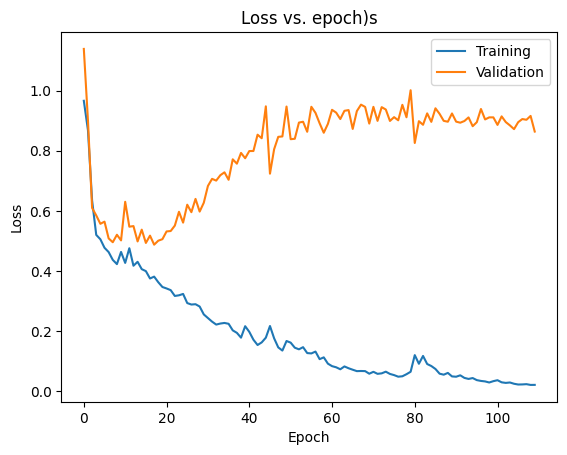

In [ ]:
# Plot the training and validation loss
loss = train_hist.history['loss']
val_loss = train_hist.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss vs. epoch)s')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

9. **Diagnose the learning curve:**
    - Why is the validation loss much higher than training loss?
    - What's this phenomenon called?
    - Mention 3 methods to reduce this.

- **answer**:
    - _Because when increasing the epochs the size of the validation data is quite small asa it's about 10% of the training data which isn't sufficient_
    - _Overfitting_
    - _1. We can reduce the Epoch numbers to `20` according to the graph._
     2. We can apply data augmentation to the trainig data to increase its number
     3. drop some features that has no relation to the other features this can be done by regularization
     4.Increase the neurons in the output layer so it learns the features much better
     5. Th validation_split value is too small that the model can't learn the data well
     6. Decrease the complexity of the model and this is by reducing the neurons numbers in each layer

10. **Use one of the methods you mentioned and retrain the model then plot the learning curves**

In [ ]:
input_shape=(train_data.shape[1])
# print(input_shape)
model1 = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu',input_shape=[input_shape]),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)]
    )
model1.compile(loss = 'mse', optimizer = 'adam', metrics=['mae'])

In [ ]:
#### YOUR CODE HERE
train_hist1 = model1.fit(train_data, train_targets_norm, epochs=110, batch_size=64, validation_split=0.3)

Epoch 1/110
5/5 [==============================] - 2s 115ms/step - loss: 8.3853 - mae: 0.8311 - val_loss: 8.0661 - val_mae: 0.9030
Epoch 2/110
5/5 [==============================] - 0s 9ms/step - loss: 7.6681 - mae: 0.8274 - val_loss: 7.3807 - val_mae: 0.8989
Epoch 3/110
5/5 [==============================] - 0s 10ms/step - loss: 7.0034 - mae: 0.8231 - val_loss: 6.7458 - val_mae: 0.8940
Epoch 4/110
5/5 [==============================] - 0s 9ms/step - loss: 6.3887 - mae: 0.8187 - val_loss: 6.1590 - val_mae: 0.8862
Epoch 5/110
5/5 [==============================] - 0s 9ms/step - loss: 5.8231 - mae: 0.8123 - val_loss: 5.6134 - val_mae: 0.8735
Epoch 6/110
5/5 [==============================] - 0s 10ms/step - loss: 5.2961 - mae: 0.7985 - val_loss: 5.0984 - val_mae: 0.8520
Epoch 7/110
5/5 [==============================] - 0s 10ms/step - loss: 4.8003 - mae: 0.7768 - val_loss: 4.5950 - val_mae: 0.8142
Epoch 8/110
5/5 [==============================] - 0s 10ms/step - loss: 4.3323 - mae: 0.7409

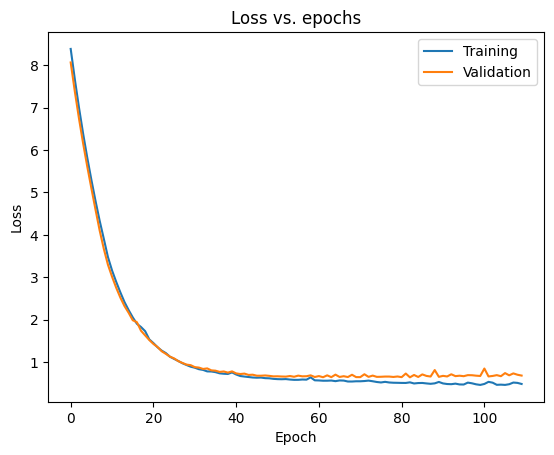

In [ ]:
# Plot the training and validation loss
loss = train_hist1.history['loss']
val_loss = train_hist1.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Part 3 Batches and Epochs

In this part of the assignment we will create a synthetic data to play with.
The data will have 2 features and 3 target classes --> multiclass classification problem

In [ ]:
# prepare train and test dataset
def prepare_data():
    #  generate classification dataset with 3 centers (labels/classes)
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)

    # plot data
    for class_value in range(3):
        # select indices of points with the class label
        row_ix = np.where(y == class_value)
        # scatter plot for points with a different color
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    # show plot
    plt.show()

    # one hot encode output variable to convert from integers to binary class
    y = to_categorical(y)

    # split into train and test
    n_train = 500
    X_train, X_test = X[:n_train, :], X[n_train:, :]
    y_train, y_test = y[:n_train], y[n_train:]
    return X_train, y_train, X_test, y_test


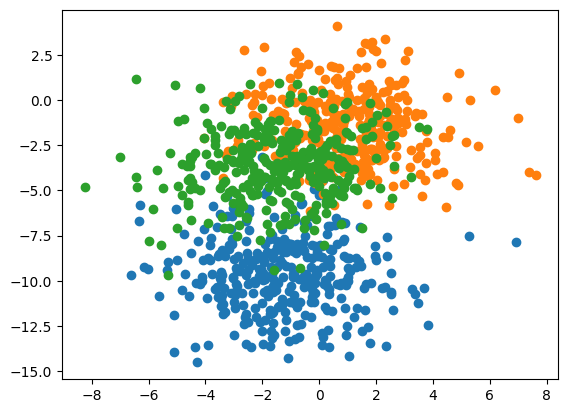

In [ ]:
# prepare dataset
X_train, y_train, X_test, y_test = prepare_data()


- **Create a model with:**
    -  1 hidden dense layer (50 neurons), activation relu, , kernel_initializer he_uniform
    - 1 output layer
    - compile the model with SGD (learning rate 0.01 and momentum 0.9) optimizer and categorical crossentropy and accuracy inside build function

In [ ]:
inShape = X_train.shape[1]
inShape

2

In [ ]:
def build_model():

    ##### YOUR CODE HERE
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(inShape,), kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

    # Compile the model
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

- Create a function to fit and build the model with different batch sizes

Use epochs = 125

In [ ]:
# fit a model and plot learning curve
def fit_model(X_train, y_train, X_test, y_test, n_batch):
    ##### YOUR CODE HERE
    model = build_model()
    history = model.fit(X_train, y_train, epochs=125, batch_size=n_batch, validation_data=(X_test, y_test), verbose=0)

    return history

### Hyperparameter Tuning

#### Batch size

##### Size =  1

10. **train for 1 batch size**

In [ ]:
### START CODE HERE ###
hist = fit_model(X_train, y_train, X_test, y_test, 1)

###### END CODE HERE

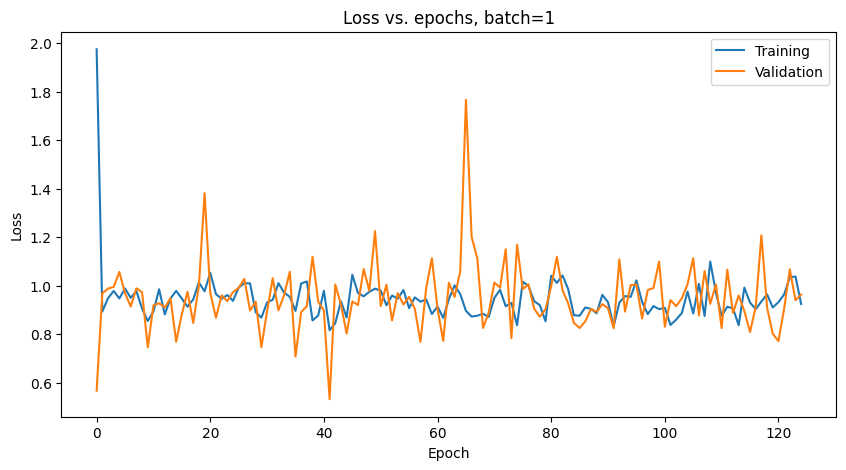

In [ ]:
batch_size = 1
plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

- **Diagnose this curve w.r.t learning rate**:
    - ANSWER: The learning rate is very high so the curve is oscilating not converging around the optimal solution
- Change learning rate to make this curve better

In [ ]:
### Your answer
lr = 0.001

In [ ]:
def build_model():

    ##### YOUR CODE HERE
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(2,), kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

    # Compile the model
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
batch_size = 1
history = fit_model(X_train, y_train, X_test, y_test, batch_size)


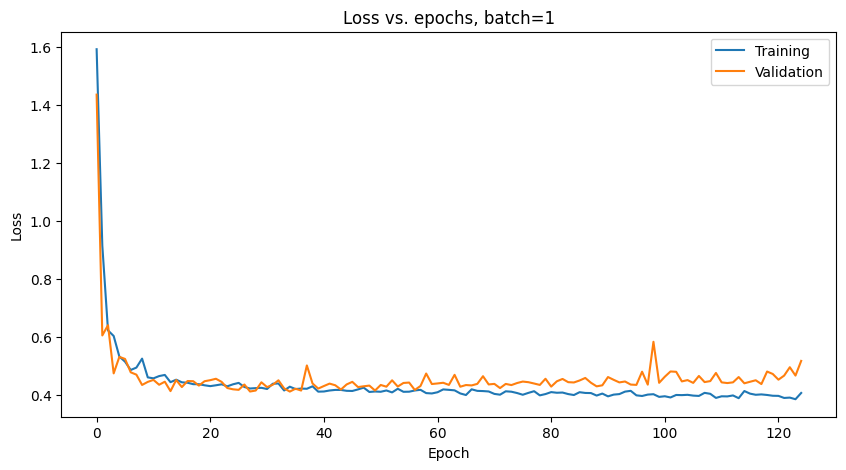

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  16

10. **Retrain for 16 batch size**

In [ ]:
### START CODE HERE ###

batch_size = 16
history2 = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

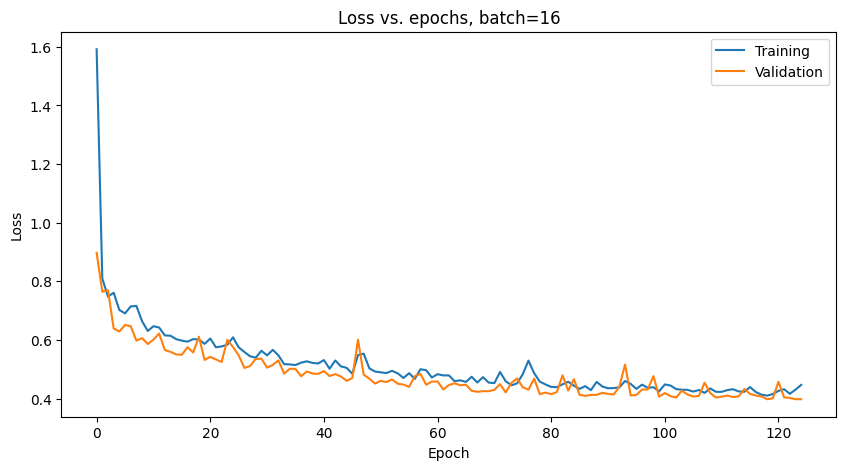

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  128

10. **Retrain for 128 batch size**

In [ ]:
### START CODE HERE ###
batch_size = 128
history2 = fit_model(X_train, y_train, X_test, y_test, batch_size)

###### END CODE HERE

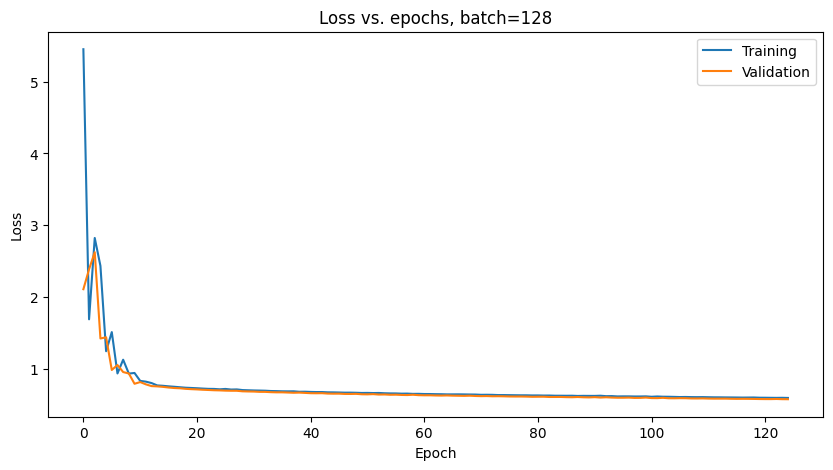

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### Size =  Data

10. **Retrain for length of data batch size**

In [ ]:
### START CODE HERE ###
batch_size = len(X_train)
history3 = fit_model(X_train, y_train, X_test, y_test, batch_size)
###### END CODE HERE

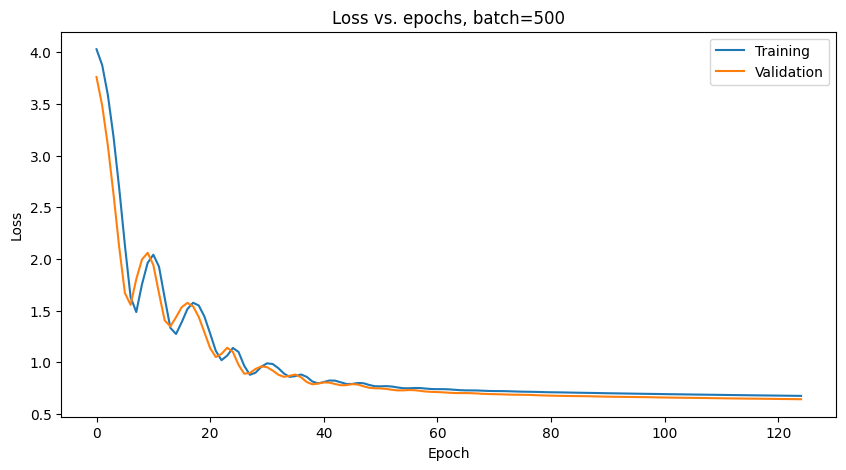

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss vs. epochs, batch=' +str(batch_size))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing batch size have on learning in terms of convergence and fluctuations?**

**Answer:** It improves the convergence of the train loss and the validation loss towards the optimal values of the parameters as they get very close to each other and the fluctations decreases as we increase the batch size till the curve become approximatly smooth



#### Learning Rate

batch size 64

- **Use same code for build_model above, add an argument learning rate to change learning rate of optmizer**

In [ ]:
def build_model(lr):

    ##### YOUR CODE HERE
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(2,), kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

    # Compile the model
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def fit_model(X_train, y_train, X_test, y_test, n_batch, lr):
    ##### YOUR CODE HERE
    model = build_model(lr)
    history = model.fit(X_train, y_train, epochs=125, batch_size=n_batch, validation_data=(X_test, y_test), verbose=0)

    return history

##### LR =  0.00001

10. **Retrain for 0.00001 LR**

In [ ]:
### START CODE HERE ### ()
n_batch = 64
lr = 0.00001
history3 = build_model(lr).fit(X_train, y_train, epochs=125, batch_size=n_batch, validation_data=(X_test, y_test), verbose=0)


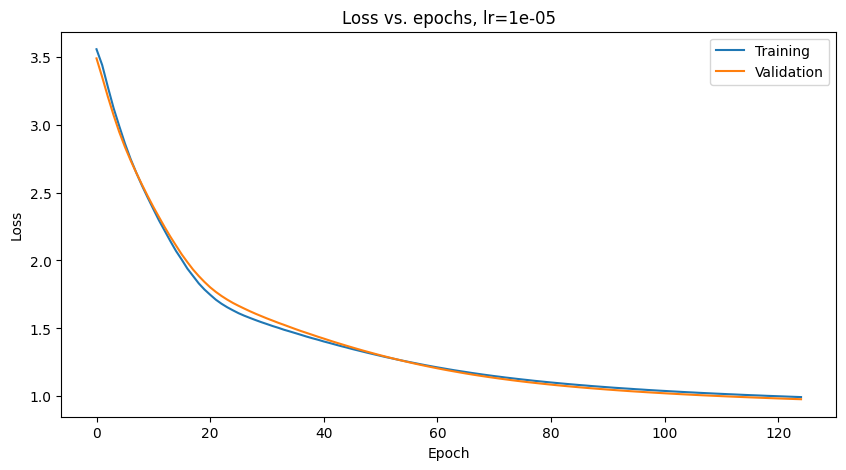

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.001

10. **Retrain for 0.001 LR**

In [ ]:
### START CODE HERE ### ()
lr = 0.001
history3 = build_model(lr).fit(X_train, y_train, epochs=125, batch_size=n_batch, validation_data=(X_test, y_test), verbose=0)

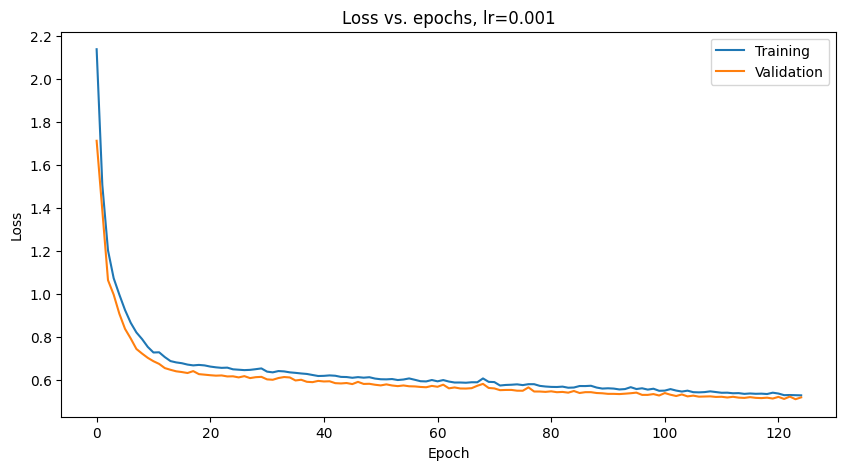

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

##### LR =  0.1

10. **Retrain for 0.1 LR**

In [ ]:
### START CODE HERE ### ()
lr = 0.1
history3 = build_model(lr).fit(X_train, y_train, epochs=125, batch_size=n_batch, validation_data=(X_test, y_test), verbose=0)

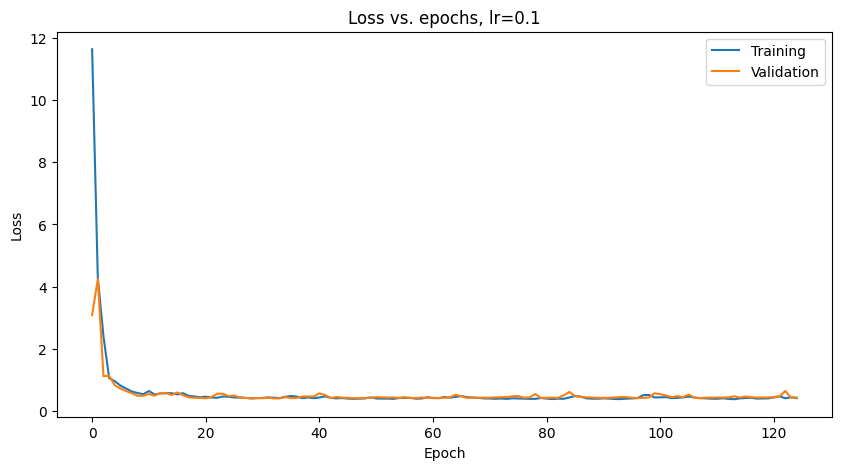

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss vs. epochs, lr=' +str(lr))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

10. **What effect does changing learning rate have on learning?**





**Answer:** The learning rate affect the model's stability and convergence speed as when its relatively small we can see that the speed of convergence is highher than when we increased the leraning rate as when learning rate is too small it may lead to slow convergence or getting stuck in local minima and make smaller weight updates
Higher learning rates: makes the optmization function to take larger steps but the learning curve won't be smooth
Lower learning rates: makes the optmization function to take smaller steps but the learning curve be quite smooth

**Questions**

1. Mention 1 advantage of a computational graph?

**Answer:** Automatic Differentiation it makes differentiation much easier and clear thus helping in optmization algorithm that based on calculating gradients e.g: SGD

2. Mention two ways to input data for training using TensorFlow if the data resides on disk

**Answer:**
1. Using the `tf.data.Dataset` API:It provides a powerful and flexible way to input data from disk______________

2.Using the `ImageDataGenerator` in Keras: When working with image data ____________